# Part III (Static Replication)
Suppose on `1-Dec-2020`, we need to evaluate an exotic European derivative expiring on `15-Jan-2021` which pays:
1. payoff function $S_T^{1/3}+1.5\times\log(S_T)+10.0$,
2. “model-free” integrated variance $\sigma_{\text{MF}}^2T=\mathbb{E}\left[\displaystyle\int_0^T\sigma_t^2\,dt\right]$.

Determine the price of these 2 derivative contracts if we use:
1. Black-Scholes model (what value of $\sigma$ should we use?)
2. Bachelier model (what value of $\sigma$ should we use?)
3. Static-replication of European payoff (using the SABR model calibrated in Part II)

# Response
We start by importing and analyzing the following items needed for our data analysis:

In [3]:
# Import the following modules as needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.integrate import quad
import warnings
warnings.filterwarnings("ignore")

# Import the following dataframes
SPX_df = pd.read_csv("SPX_options.csv")
SPY_df = pd.read_csv("SPY_options.csv")
zero_rates_df = pd.read_csv("zero_rates_20201201.csv")

# Analyze SPX index value data and SPY stock value data
SPX_df["mid"] = 0.5 * (SPX_df["best_bid"] + SPX_df["best_offer"])
SPX_df["strike"] = 0.001 * SPX_df["strike_price"]
SPX_df["payoff"] = SPX_df["cp_flag"]\
                                    .map(lambda x: "call"\
                                         if x == "C"\
                                         else "put")
SPY_df["mid"] = 0.5 * (SPY_df["best_bid"] + SPY_df["best_offer"])
SPY_df["strike"] = 0.001 * SPY_df["strike_price"]
SPY_df["payoff"] = SPY_df["cp_flag"]\
                                    .map(lambda x: "call"\
                                         if x == "C"\
                                         else "put")

# We see that stocks expiring on 15-Jan-2021 have a time to maturity of 45 days
exdate = sorted(SPX_df["exdate"]
                 .unique()
                )[1]
time_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp("2020-12-01")).days # = 45 days

T = time_to_expiry/365

SPX_df1 = SPX_df\
                [SPX_df["exdate"] == exdate]
SPY_df1 = SPY_df\
                [SPY_df["exdate"] == exdate]
SPX_value = 3662.45
SPY_value = 366.02
SPX_df_BS = SPX_df1.copy()
SPY_df_BS = SPY_df1.copy()
SPX_df_Bav = SPX_df1.copy()
SPY_df_Bav = SPY_df1.copy()

# Relevant values from part 2 that can be used
r = 0.002051
F0_SPX = SPX_value * np.exp(r * T)
F0_SPY = SPY_value * np.exp(r * T)

# SABR model parameters
alpha_SPX = 0.6654021853245597
beta_SPX = 0.7
rho_SPX = -0.4118998606736283
nu_SPX = 5.249981439124839

alpha_SPY = 0.90813
beta_SPY = 0.7
rho_SPY = -0.48878
nu_SPY = 2.72852

We first consider the Black-Scholes model.

In [5]:
def C_BSv(S0, K, r, sigma, T): # call for European option
    d1 = (np.log(S0/K) + (r + sigma**2/2) * T)/(sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def P_BSv(S0, K, r, sigma, T): # put for European option
    d1 = (np.log(S0/K) + (r + sigma**2/2) * T)/(sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)

def impliedVol_BS(S0, K, r, price, T, payoff):
    try:
        if (payoff.lower() == "call"):
            impliedVol = brentq(lambda x: C_BSv(S0, K, r, x, T) -
                                price,
                                1e-12,
                                1000.0)
        elif (payoff.lower() == "put"):
            impliedVol = brentq(lambda x: price -
                                P_BSv(S0, K, r, x, T),
                                1e-12,
                                1000.0)
        else:
            raise NameError("Payoff type not recognized")
    except Exception:
        impliedVol = np.nan
    return impliedVol

SPX_df_BS["vol_BS"] = SPX_df_BS.apply(
    lambda x: impliedVol_BS(SPX_value,
                            x["strike"],
                            r,
                            x["mid"],
                            T,
                            x["payoff"]), axis = 1)
SPY_df_BS["vol_BS"] = SPY_df_BS.apply(
    lambda x: impliedVol_BS(SPY_value,
                            x["strike"],
                            r,
                            x["mid"],
                            T,
                            x["payoff"]), axis = 1)

SPX_df_BS.dropna(inplace=True)
SPY_df_BS.dropna(inplace=True)

def transf_to_impliedVol_BS(df, S0):
    C_df = df[df["payoff"] == "call"]
    P_df = df[df["payoff"] == "put"]
    strike_prices = P_df["strike"].values
    implied_vols = []
    payoffs = []
    prices = []
    for K in strike_prices:    
        if S0 < K:
            implied_vols.append(
                C_df[C_df["strike"] == K]["vol_BS"].values[0]
            )
            payoffs.append(
                C_df[C_df["strike"] == K]["payoff"].values[0]
            )
            prices.append(
                C_df[C_df["strike"] == K]["mid"].values[0]
            )
        else:
            implied_vols.append(
                P_df[P_df["strike"] == K]["vol_BS"].values[0]
            )
            payoffs.append(
                P_df[P_df["strike"] == K]["payoff"].values[0]
            )
            prices.append(
                P_df[P_df["strike"] == K]["mid"].values[0]
            )

    df = pd.DataFrame({"implied_vol": implied_vols})
    return df["implied_vol"].mean() # we choose the mean market-implied volatility as our preferred sigma

SPX_df_BS_sigma = transf_to_impliedVol_BS(SPX_df_BS, SPX_value)
SPY_df_BS_sigma = transf_to_impliedVol_BS(SPY_df_BS, SPY_value)

Next, we consider the Bachelier model.

In [7]:
def C_Bav(S0, K, r, sigma, T):
    d = (S0 - K)/(sigma * np.sqrt(T))
    return np.exp(-r * T) * ((S0 - K) * norm.cdf(d) + sigma * np.sqrt(T) * norm.pdf(d))

def P_Bav(S0, K, r, sigma, T):
    d = (S0 - K)/(sigma * np.sqrt(T))
    return np.exp(-r * T) * ((K - S0) * norm.cdf(-d) + sigma * np.sqrt(T) * norm.pdf(-d))

def impliedVol_Bav(S0, K, r, price, T, payoff):
    try:
        if (payoff.lower() == "call"):
            impliedVol = brentq(lambda x: C_Bav(S0, K, r, x, T) -
                                price,
                                1e-12,
                                1000.0)
        elif (payoff.lower() == "put"):
            impliedVol = brentq(lambda x: price -
                                P_Bav(S0, K, r, x, T),
                                1e-12,
                                1000.0)
        else:
            raise NameError("Payoff type not recognized")
    except Exception:
        impliedVol = np.nan
    return impliedVol

SPX_df_Bav["vol_Bav"] = SPX_df_Bav.apply(
    lambda x: impliedVol_Bav(SPX_value,
                             x["strike"],
                             r,
                             x["mid"],
                             T,
                             x["payoff"]), axis = 1)
SPY_df_Bav["vol_Bav"] = SPY_df_Bav.apply(
    lambda x: impliedVol_Bav(SPY_value,
                             x["strike"],
                             r,
                             x["mid"],
                             T,
                             x["payoff"]), axis = 1)

SPX_df_Bav.dropna(inplace=True)
SPY_df_Bav.dropna(inplace=True)

def transf_to_impliedVol_Bav(df, S0):
    C_df = df[df["payoff"] == "call"]
    P_df = df[df["payoff"] == "put"]
    strike_prices = P_df["strike"].values
    implied_vols = []
    payoffs = []
    prices = []
    for K in strike_prices:    
        if S0 < K:
            implied_vols.append(
                C_df[C_df["strike"] == K]["vol_Bav"].values[0]
            )
            payoffs.append(
                C_df[C_df["strike"] == K]["payoff"].values[0]
            )
            prices.append(
                C_df[C_df["strike"] == K]["mid"].values[0]
            )
        else:
            implied_vols.append(
                P_df[P_df["strike"] == K]["vol_Bav"].values[0]
            )
            payoffs.append(
                P_df[P_df["strike"] == K]["payoff"].values[0]
            )
            prices.append(
                P_df[P_df["strike"] == K]["mid"].values[0]
            )

    df = pd.DataFrame({"implied_vol": implied_vols})
    return df["implied_vol"].mean() # we choose the mean market-implied volatility as our preferred sigma

SPX_df_Bav_sigma = transf_to_impliedVol_Bav(SPX_df_Bav, SPX_value)
SPY_df_Bav_sigma = transf_to_impliedVol_Bav(SPY_df_Bav, SPY_value)

Finally, we consider the SABR model.

In [9]:
def SABR(F0, K, T, alpha, beta, rho, nu):
    X = K
    # if K is ATM forward
    if abs(F0 - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24) * alpha**2/(F0 ** (2 - 2 * beta))
        numer2 = 0.25 * rho * beta * nu * alpha/(F0 ** (1 - beta))
        numer3 = ((2 - 3 * rho**2)/24) * nu**2
        VolAtm = alpha * (1 + (numer1 + numer2 + numer3) * T)/(F0 ** (1 - beta))
        SABR_sigma = VolAtm
    else:
        z = (nu/alpha) * ((F0 * X) ** (0.5 * (1 - beta))) * np.log(F0/X)
        zhi = np.log((((1 - 2 * rho * z + z**2)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*(alpha**2/((F0 * X)**(1 - beta)))
        numer2 = 0.25 * rho * beta * nu * alpha/((F0 * X)**((1 - beta)/2))
        numer3 = ((2 - 3 * rho**2)/24) * nu**2
        numer = alpha * (1 + (numer1 + numer2 + numer3) * T) * z
        denom1 = ((1 - beta)**2/24) * (np.log(F0/X))**2
        denom2 = (((1 - beta)**4)/1920) * ((np.log(F0/X))**4)
        denom = ((F0 * X)**((1 - beta)/2)) * (1 + denom1 + denom2) * zhi
        SABR_sigma = numer/denom
    return SABR_sigma

def C_SABR(S0, K, r, T, alpha, beta, rho, nu):
    vol_SABR = SABR(S0 * np.exp(r * T), K, T, alpha, beta, rho, nu)
    return C_BSv(S0, K, r, vol_SABR, T)

def P_SABR(S0, K, r, T, alpha, beta, rho, nu):
    vol_SABR = SABR(S0 * np.exp(r * T), K, T, alpha, beta, rho, nu)
    return P_BSv(S0, K, r, vol_SABR, T)

Given the payoff function $h(S_T) = S^{1/3}_T + 1.5\log(S_T) + 10.0$, we have $h'(S_T) = \frac{1}{3}S^{-\frac{2}{3}}_T + \frac{3}{2}S^{-1}_T$ and $h''(S_T) = -\frac{2}{9}S^{-\frac{5}{3}}_T - \frac{3}{2}S^{-2}_T$.

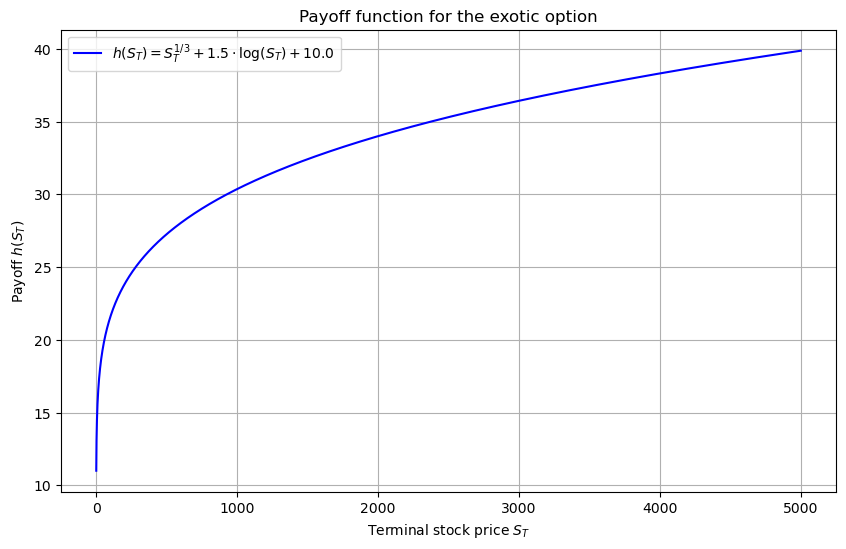

In [11]:
def h(K):
    K = np.where(np.abs(K) < 1e-12, 1e-12, K)
    return K**(1/3) + 1.5 * np.log(K) + 10

def h2(K):
    K = np.where(np.abs(K) < 1e-12, 1e-12, K)
    return -2/9 * K**(-5/3) - 3/2 * K**(-2)

K_values = np.linspace(1, 5000, 5000)

payoff_values = h(K_values)

plt.figure(figsize=(10, 6))
plt.plot(K_values, payoff_values, label=r'$h(S_T) = S_T^{1/3} + 1.5 \cdot \log(S_T) + 10.0$', color="blue")
plt.xlabel("Terminal stock price $S_T$")
plt.ylabel("Payoff $h(S_T)$")
plt.title("Payoff function for the exotic option")
plt.legend()
plt.grid(True)
plt.show()

Then, the derivative contract is given by: $V_0 = e^{-rT}h(F) + \underbrace{\int_0^{F}h''(K)P(K)\;dK}_{\mbox{put integral}} + \underbrace{\int_{F}^{\infty}h''(K)C(K)\;dK}_{\mbox{call integral}}$.

In [13]:
# Black-Scholes
def C_BS_int1(S0, K, r, sigma, T):
    return h2(K) * C_BSv(S0, K, r, sigma, T)

def P_BS_int1(S0, K, r, sigma, T):
    return h2(K) * P_BSv(S0, K, r, sigma, T)

I_SPX_call = quad(lambda x: C_BS_int1(SPX_value, x, r, SPX_df_BS_sigma, T), F0_SPX, 5000)[0]
I_SPX_put = quad(lambda x: P_BS_int1(SPX_value, x, r, SPX_df_BS_sigma, T), 0.0, F0_SPX)[0]
I_SPY_call = quad(lambda x: C_BS_int1(SPY_value, x, r, SPY_df_BS_sigma, T), F0_SPY, 5000)[0]
I_SPY_put = quad(lambda x: P_BS_int1(SPY_value, x, r, SPY_df_BS_sigma, T), 0.0, F0_SPY)[0]
V0_SPX_BS = np.exp(-r * T) * h(F0_SPX) + I_SPX_call + I_SPX_put
V0_SPY_BS = np.exp(-r * T) * h(F0_SPY) + I_SPY_call + I_SPY_put
print('V₀ for SPX under Black-Scholes is: %.9f' % V0_SPX_BS)
print('V₀ for SPY under Black-Scholes is: %.9f' % V0_SPY_BS)

V₀ for SPX under Black-Scholes is: 37.670079863
V₀ for SPY under Black-Scholes is: 25.963384903


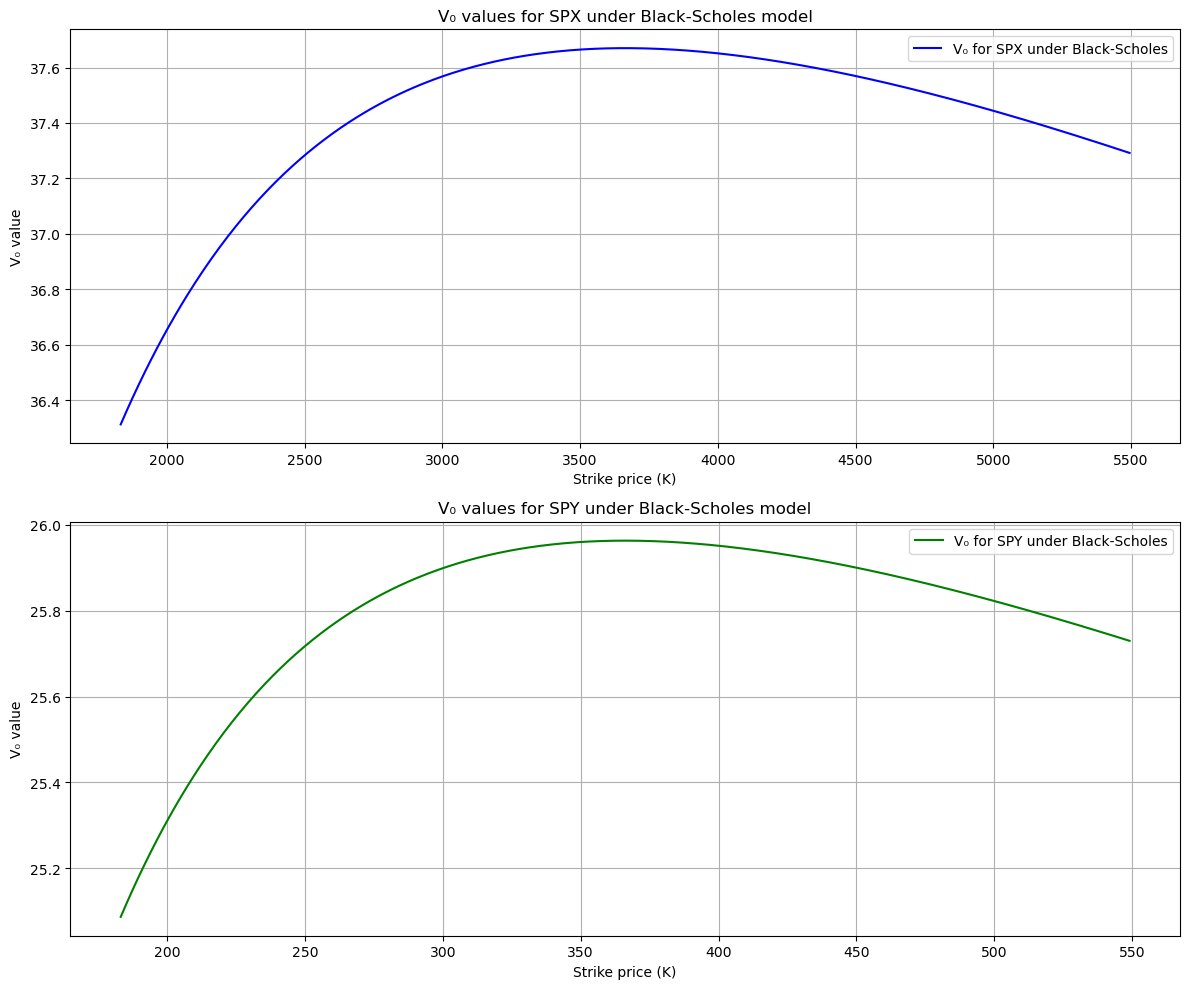

In [14]:
K_values_X = np.linspace(0.5 * F0_SPX, 1.5 * F0_SPX, 501)
K_values_Y = np.linspace(0.5 * F0_SPY, 1.5 * F0_SPY, 501)

V0_SPX_BS_values = []
V0_SPY_BS_values = []

for K in K_values_X:
    I_SPX_call = quad(lambda x: C_BS_int1(SPX_value, x, r, SPX_df_BS_sigma, T), K, 5000)[0]
    I_SPX_put = quad(lambda x: P_BS_int1(SPX_value, x, r, SPX_df_BS_sigma, T), 0.0, K)[0]
    V0_SPX_plot = np.exp(-r * T) * h(F0_SPX) + I_SPX_call + I_SPX_put
    V0_SPX_BS_values.append(V0_SPX_plot)

for K in K_values_Y:
    I_SPY_call = quad(lambda x: C_BS_int1(SPY_value, x, r, SPY_df_BS_sigma, T), K, 5000)[0]
    I_SPY_put = quad(lambda x: P_BS_int1(SPY_value, x, r, SPY_df_BS_sigma, T), 0.0, K)[0]
    V0_SPY_plot = np.exp(-r * T) * h(F0_SPY) + I_SPY_call + I_SPY_put
    V0_SPY_BS_values.append(V0_SPY_plot)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(K_values_X, V0_SPX_BS_values, label="V₀ for SPX under Black-Scholes", color="blue")
ax1.set_xlabel("Strike price (K)")
ax1.set_ylabel("V₀ value")
ax1.set_title("V₀ values for SPX under Black-Scholes model")
ax1.legend()
ax1.grid(True)

ax2.plot(K_values_Y, V0_SPY_BS_values, label="V₀ for SPY under Black-Scholes", color="green")
ax2.set_xlabel("Strike price (K)")
ax2.set_ylabel("V₀ value")
ax2.set_title("V₀ values for SPY under Black-Scholes model")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [15]:
# Bachelier
def C_Bav_int1(S0, K, r, sigma, T):
    return h2(K) * C_Bav(S0, K, r, sigma, T)

def P_Bav_int1(S0, K, r, sigma, T):
    return h2(K) * P_Bav(S0, K, r, sigma, T)

I_SPX_call = quad(lambda x: C_Bav_int1(SPX_value, x, r, SPX_df_Bav_sigma, T), F0_SPX, 5000)[0]
I_SPX_put = quad(lambda x: P_Bav_int1(SPX_value, x, r, SPX_df_Bav_sigma, T), 0.0, F0_SPX)[0]
I_SPY_call = quad(lambda x: C_Bav_int1(SPY_value, x, r, SPY_df_Bav_sigma, T), F0_SPY, 5000)[0]
I_SPY_put = quad(lambda x: P_Bav_int1(SPY_value, x, r, SPY_df_Bav_sigma, T), 0.0, F0_SPY)[0]
V0_SPX_Bav = np.exp(-r * T) * h(F0_SPX) + I_SPX_call + I_SPX_put
V0_SPY_Bav = np.exp(-r * T) * h(F0_SPY) + I_SPY_call + I_SPY_put
print('V₀ for SPX under Bachelier is: %.9f' % V0_SPX_Bav)
print('V₀ for SPY under Bachelier is: %.9f' % V0_SPY_Bav)

V₀ for SPX under Bachelier is: 37.702572658
V₀ for SPY under Bachelier is: 25.978367677


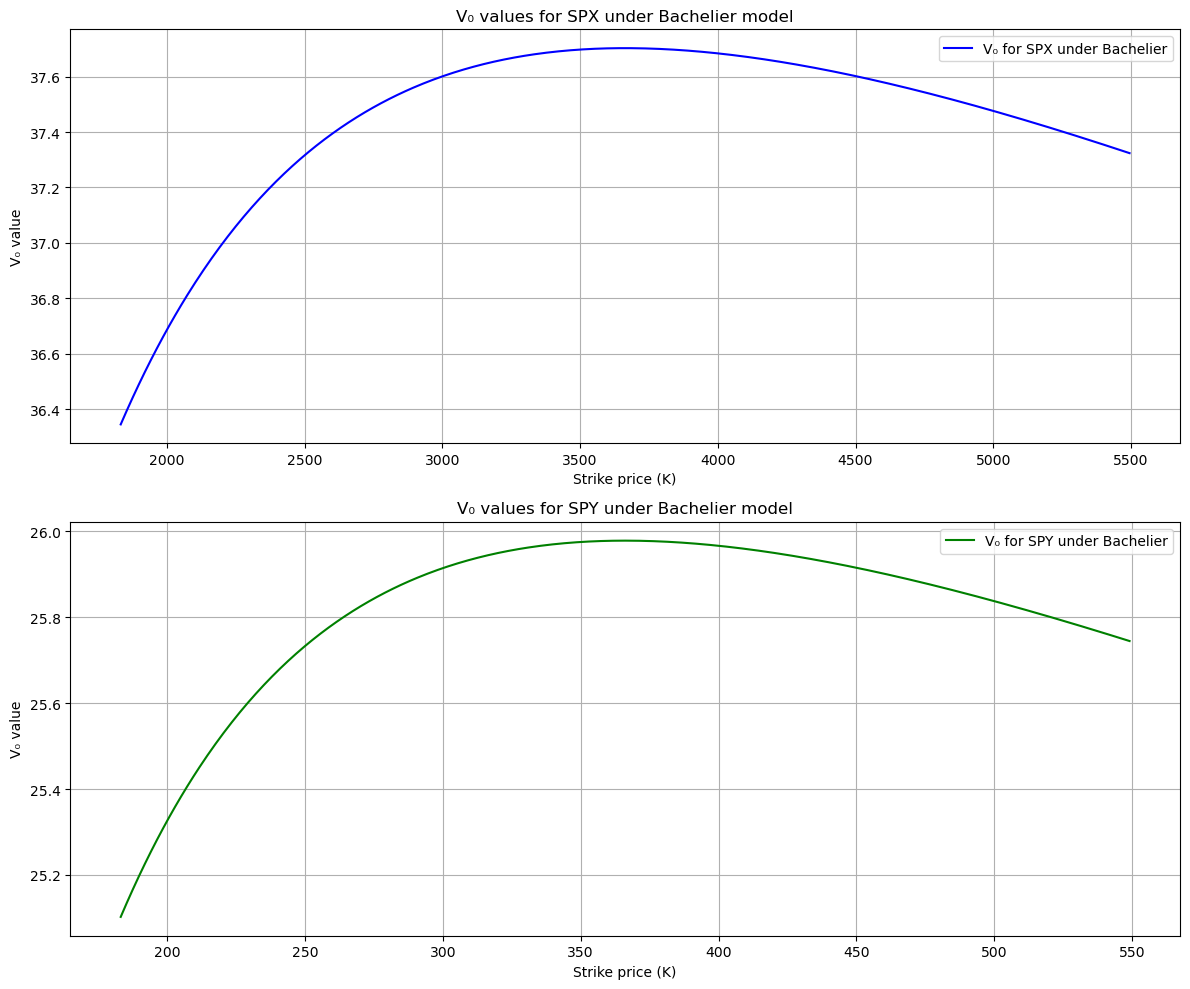

In [16]:
V0_SPX_Bav_values = []
V0_SPY_Bav_values = []

for K in K_values_X:
    I_SPX_call = quad(lambda x: C_Bav_int1(SPX_value, x, r, SPX_df_Bav_sigma, T), K, 5000)[0]
    I_SPX_put = quad(lambda x: P_Bav_int1(SPX_value, x, r, SPX_df_Bav_sigma, T), 0.0, K)[0]
    V0_SPX_plot = np.exp(-r * T) * h(F0_SPX) + I_SPX_call + I_SPX_put
    V0_SPX_Bav_values.append(V0_SPX_plot)

for K in K_values_Y:
    I_SPY_call = quad(lambda x: C_Bav_int1(SPY_value, x, r, SPY_df_Bav_sigma, T), K, 5000)[0]
    I_SPY_put = quad(lambda x: P_Bav_int1(SPY_value, x, r, SPY_df_Bav_sigma, T), 0.0, K)[0]
    V0_SPY_plot = np.exp(-r * T) * h(F0_SPY) + I_SPY_call + I_SPY_put
    V0_SPY_Bav_values.append(V0_SPY_plot)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(K_values_X, V0_SPX_Bav_values, label="V₀ for SPX under Bachelier", color="blue")
ax1.set_xlabel("Strike price (K)")
ax1.set_ylabel("V₀ value")
ax1.set_title("V₀ values for SPX under Bachelier model")
ax1.legend()
ax1.grid(True)

ax2.plot(K_values_Y, V0_SPY_Bav_values, label="V₀ for SPY under Bachelier", color="green")
ax2.set_xlabel("Strike price (K)")
ax2.set_ylabel("V₀ value")
ax2.set_title("V₀ values for SPY under Bachelier model")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [17]:
# SABR
def C_SABR_int1(S0, K, r, T, alpha, beta, rho, nu):
    return h2(K) * C_SABR(S0, K, r, T, alpha, beta, rho, nu)

def P_SABR_int1(S0, K, r, T, alpha, beta, rho, nu):
    return h2(K) * P_SABR(S0, K, r, T, alpha, beta, rho, nu)

I_SPX_call = quad(lambda x: C_SABR_int1(SPX_value, x, r, T, alpha_SPX, beta_SPX, rho_SPX, nu_SPX), F0_SPX, 5000)[0]
I_SPX_put = quad(lambda x: P_SABR_int1(SPX_value, x, r, T, alpha_SPX, beta_SPX, rho_SPX, nu_SPX), 0.0, F0_SPX)[0]
I_SPY_call = quad(lambda x: C_SABR_int1(SPY_value, x, r, T, alpha_SPY, beta_SPY, rho_SPY, nu_SPY), F0_SPY, 5000)[0]
I_SPY_put = quad(lambda x: P_SABR_int1(SPY_value, x, r, T, alpha_SPY, beta_SPY, rho_SPY, nu_SPY), 0.0, F0_SPY)[0]
V0_SPX_SABR = np.exp(-r * T) * h(F0_SPX) + I_SPX_call + I_SPX_put
V0_SPY_SABR = np.exp(-r * T) * h(F0_SPY) + I_SPY_call + I_SPY_put
print('V₀ for SPX under SABR is: %.9f' % V0_SPX_SABR)
print('V₀ for SPY under SABR is: %.9f' % V0_SPY_SABR)

V₀ for SPX under SABR is: 37.505592894
V₀ for SPY under SABR is: 25.992662836


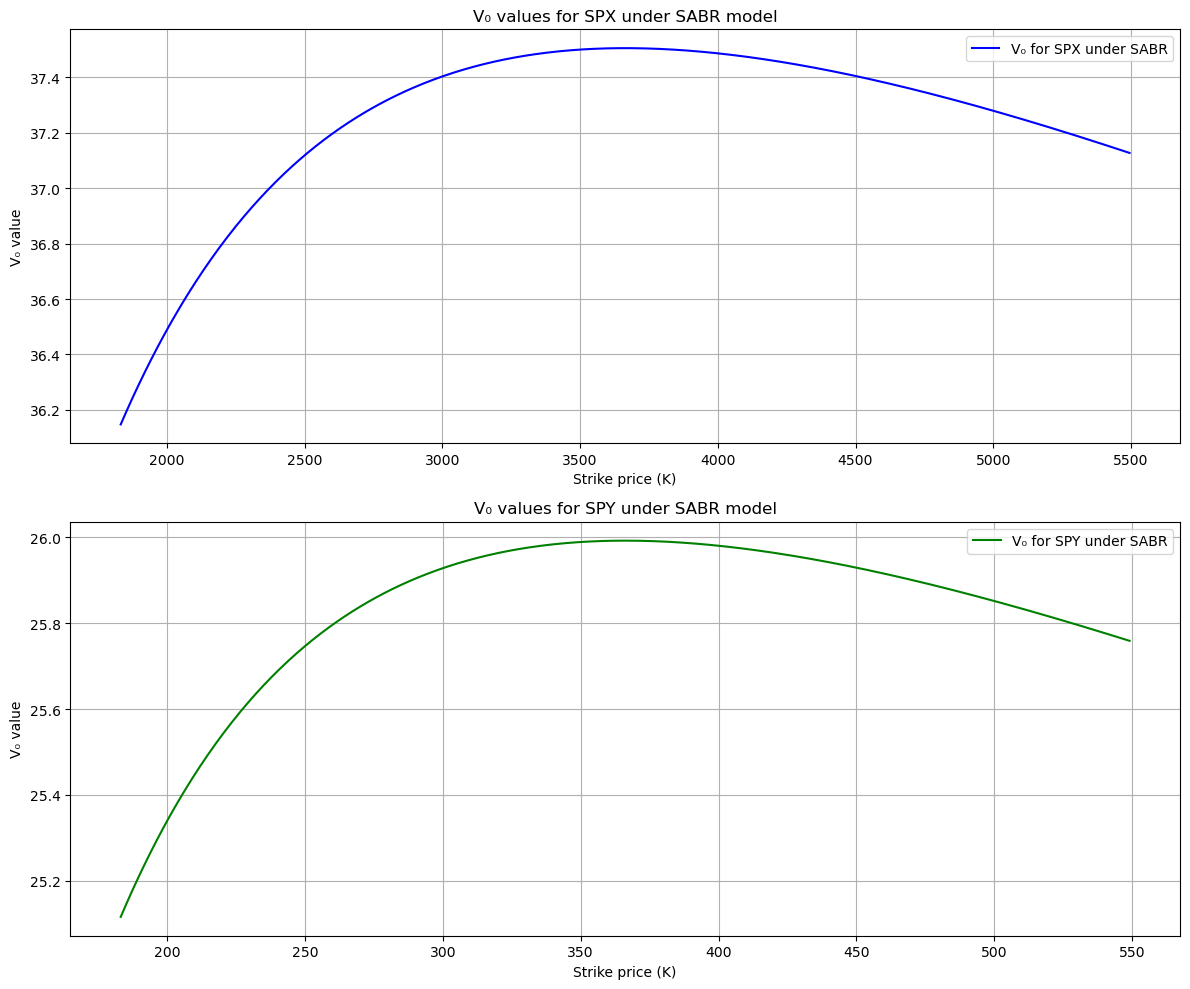

In [18]:
V0_SPX_SABR_values = []
V0_SPY_SABR_values = []

for K in K_values_X:
    I_SPX_call = quad(lambda x: C_SABR_int1(SPX_value, x, r, T, alpha_SPX, beta_SPX, rho_SPX, nu_SPX), K, 5000)[0]
    I_SPX_put = quad(lambda x: P_SABR_int1(SPX_value, x, r, T, alpha_SPX, beta_SPX, rho_SPX, nu_SPX), 0.0, K)[0]
    V0_SPX_plot = np.exp(-r * T) * h(F0_SPX) + I_SPX_call + I_SPX_put
    V0_SPX_SABR_values.append(V0_SPX_plot)

for K in K_values_Y:
    I_SPY_call = quad(lambda x: C_SABR_int1(SPY_value, x, r, T, alpha_SPY, beta_SPY, rho_SPY, nu_SPY), K, 5000)[0]
    I_SPY_put = quad(lambda x: P_SABR_int1(SPY_value, x, r, T, alpha_SPY, beta_SPY, rho_SPY, nu_SPY), 0.0, K)[0]
    V0_SPY_plot = np.exp(-r * T) * h(F0_SPY) + I_SPY_call + I_SPY_put
    V0_SPY_SABR_values.append(V0_SPY_plot)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(K_values_X, V0_SPX_SABR_values, label="V₀ for SPX under SABR", color="blue")
ax1.set_xlabel("Strike price (K)")
ax1.set_ylabel("V₀ value")
ax1.set_title("V₀ values for SPX under SABR model")
ax1.legend()
ax1.grid(True)

ax2.plot(K_values_Y, V0_SPY_SABR_values, label="V₀ for SPY under SABR", color="green")
ax2.set_xlabel("Strike price (K)")
ax2.set_ylabel("V₀ value")
ax2.set_title("V₀ values for SPY under SABR model")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

We can test our static replication implementation with $\mathbb{E}\left[\int_0^T\sigma_t^2 \;dt\right] = 2e^{rT} \left(\int_0^{F}\frac{P(K)}{K^2}\;dK + \int_{F}^{\infty}\frac{C(K)}{K^2}\;dK\right)$.

In [20]:
# “Model-free” integrated variance using the Black-Scholes model
def C_BS_int2(S0, K, r, sigma, T):
    return C_BSv(S0, K, r, sigma, T) / K**2

def P_BS_int2(S0, K, r, sigma, T):
    return P_BSv(S0, K, r, sigma, T) / K**2

I_SPX_call = quad(lambda x: C_BS_int2(SPX_value, x, r, SPX_df_BS_sigma, T), F0_SPX, 5000)[0]
I_SPX_put = quad(lambda x: P_BS_int2(SPX_value, x, r, SPX_df_BS_sigma, T), 0.0, F0_SPX)[0]
I_SPY_call = quad(lambda x: C_BS_int2(SPY_value, x, r, SPY_df_BS_sigma, T), F0_SPY, 5000)[0]
I_SPY_put = quad(lambda x: P_BS_int2(SPY_value, x, r, SPY_df_BS_sigma, T), 0.0, F0_SPY)[0]

E_SPX_var = 2 * np.exp(r * T) * (I_SPX_call + I_SPX_put)
E_SPY_var = 2 * np.exp(r * T) * (I_SPY_call + I_SPY_put)
print('The expected integrated variance for SPX under Black-Scholes is: %.9f' % E_SPX_var)
print('The expected integrated variance for SPY under Black-Scholes is: %.9f' % E_SPY_var)

MF_SPX_var = E_SPX_var/T
MF_SPY_var = E_SPY_var/T
print('The “model-free” integrated variance for SPX under Black-Scholes is: %.9f' % MF_SPX_var)
print('The “model-free” integrated variance for SPY under Black-Scholes is: %.9f' % MF_SPY_var)

print('Hence, the desired σ for SPX under Black-Scholes is: %.3f' % np.sqrt(MF_SPX_var))
print('Hence, the desired σ for SPY under Black-Scholes is: %.3f' % np.sqrt(MF_SPY_var))

The expected integrated variance for SPX under Black-Scholes is: 0.018371777
The expected integrated variance for SPY under Black-Scholes is: 0.024798745
The “model-free” integrated variance for SPX under Black-Scholes is: 0.149015526
The “model-free” integrated variance for SPY under Black-Scholes is: 0.201145375
Hence, the desired σ for SPX under Black-Scholes is: 0.386
Hence, the desired σ for SPY under Black-Scholes is: 0.448


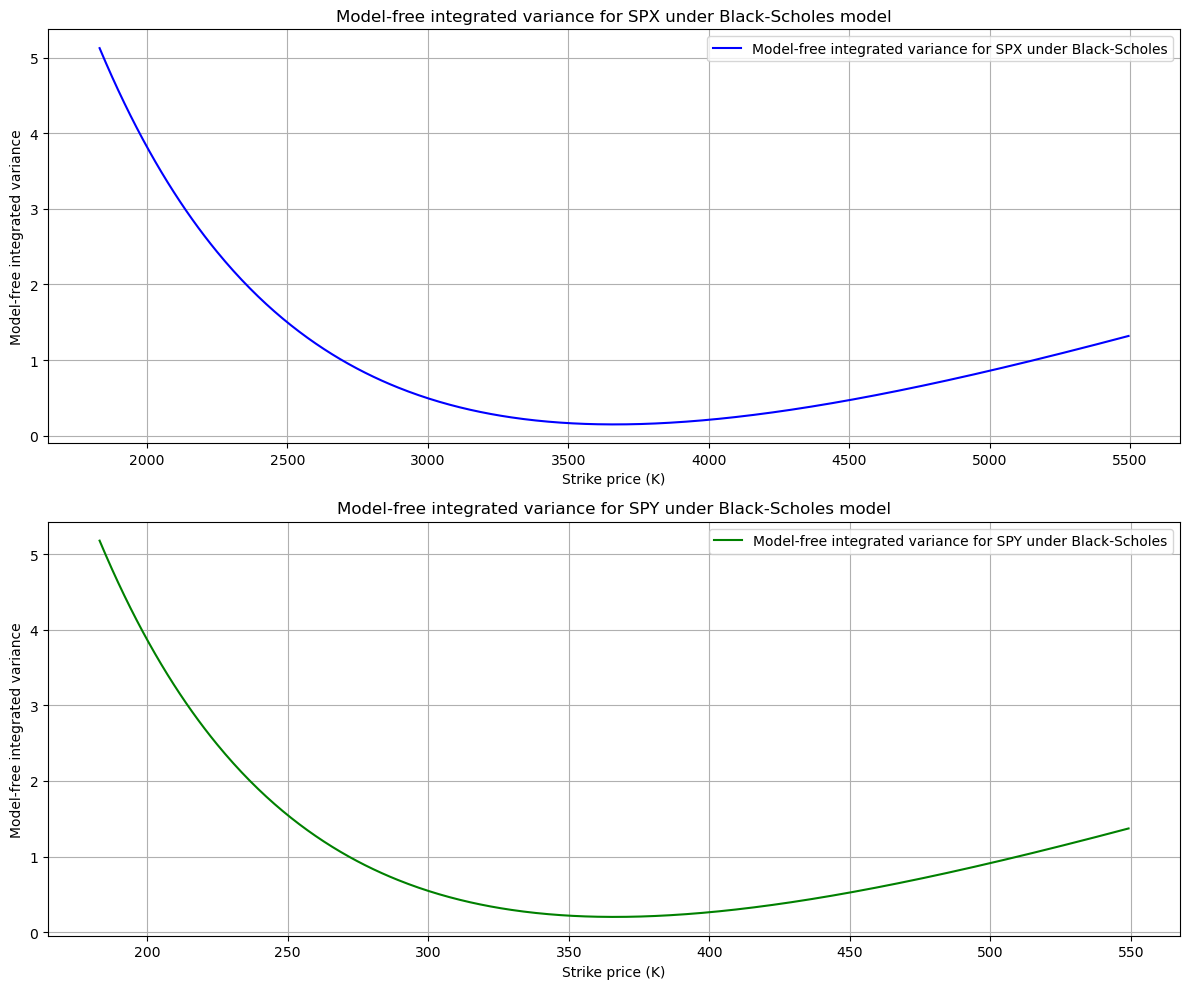

In [21]:
MF_SPX_BS_values = []
MF_SPY_BS_values = []

for K in K_values_X:
    I_SPX_call = quad(lambda x: C_BS_int2(SPX_value, x, r, SPX_df_BS_sigma, T), K, 5000)[0]
    I_SPX_put = quad(lambda x: P_BS_int2(SPX_value, x, r, SPX_df_BS_sigma, T), 0.0, K)[0]
    E_SPX_var = 2 * np.exp(r * T) * (I_SPX_call + I_SPX_put)
    MF_SPX_var_plot = E_SPX_var / T
    MF_SPX_BS_values.append(MF_SPX_var_plot)

for K in K_values_Y:
    I_SPY_call = quad(lambda x: C_BS_int2(SPY_value, x, r, SPY_df_BS_sigma, T), K, 5000)[0]
    I_SPY_put = quad(lambda x: P_BS_int2(SPY_value, x, r, SPY_df_BS_sigma, T), 0.0, K)[0]
    E_SPY_var = 2 * np.exp(r * T) * (I_SPY_call + I_SPY_put)
    MF_SPY_var_plot = E_SPY_var / T
    MF_SPY_BS_values.append(MF_SPY_var_plot)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(K_values_X, MF_SPX_BS_values, label="Model-free integrated variance for SPX under Black-Scholes", color="blue")
ax1.set_xlabel("Strike price (K)")
ax1.set_ylabel("Model-free integrated variance")
ax1.set_title("Model-free integrated variance for SPX under Black-Scholes model")
ax1.legend()
ax1.grid(True)

ax2.plot(K_values_Y, MF_SPY_BS_values, label="Model-free integrated variance for SPY under Black-Scholes", color="green")
ax2.set_xlabel("Strike price (K)")
ax2.set_ylabel("Model-free integrated variance")
ax2.set_title("Model-free integrated variance for SPY under Black-Scholes model")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [22]:
# “Model-free” integrated variance using the Bachelier model
def C_Bav_int2(S0, K, r, sigma, T):
    return C_Bav(S0, K, r, sigma, T) / K**2

def P_Bav_int2(S0, K, r, sigma, T):
    return P_Bav(S0, K, r, sigma, T) / K**2

I_SPX_call = quad(lambda x: C_Bav_int2(SPX_value, x, r, SPX_df_Bav_sigma, T), F0_SPX, 5000)[0]
I_SPX_put = quad(lambda x: P_Bav_int2(SPX_value, x, r, SPX_df_Bav_sigma, T), 0.0, F0_SPX)[0]
I_SPY_call = quad(lambda x: C_Bav_int2(SPY_value, x, r, SPY_df_Bav_sigma, T), F0_SPY, 5000)[0]
I_SPY_put = quad(lambda x: P_Bav_int2(SPY_value, x, r, SPY_df_Bav_sigma, T), 0.0, F0_SPY)[0]

E_SPX_var = 2 * np.exp(r * T) * (I_SPX_call + I_SPX_put)
E_SPY_var = 2 * np.exp(r * T) * (I_SPY_call + I_SPY_put)
print('The expected integrated variance for SPX under Bachelier is: %.9f' % E_SPX_var)
print('The expected integrated variance for SPY under Bachelier is: %.9f' % E_SPY_var)

MF_SPX_var = E_SPX_var/T
MF_SPY_var = E_SPY_var/T
print('The “model-free” integrated variance for SPX under Bachelier is: %.9f' % MF_SPX_var)
print('The “model-free” integrated variance for SPY under Bachelier is: %.9f' % MF_SPY_var)

print('Hence, the desired σ for SPX under Bachelier is: %.3f' % np.sqrt(MF_SPX_var))
print('Hence, the desired σ for SPY under Bachelier is: %.3f' % np.sqrt(MF_SPY_var))

The expected integrated variance for SPX under Bachelier is: 0.005166615
The expected integrated variance for SPY under Bachelier is: 0.015128057
The “model-free” integrated variance for SPX under Bachelier is: 0.041906990
The “model-free” integrated variance for SPY under Bachelier is: 0.122705353
Hence, the desired σ for SPX under Bachelier is: 0.205
Hence, the desired σ for SPY under Bachelier is: 0.350


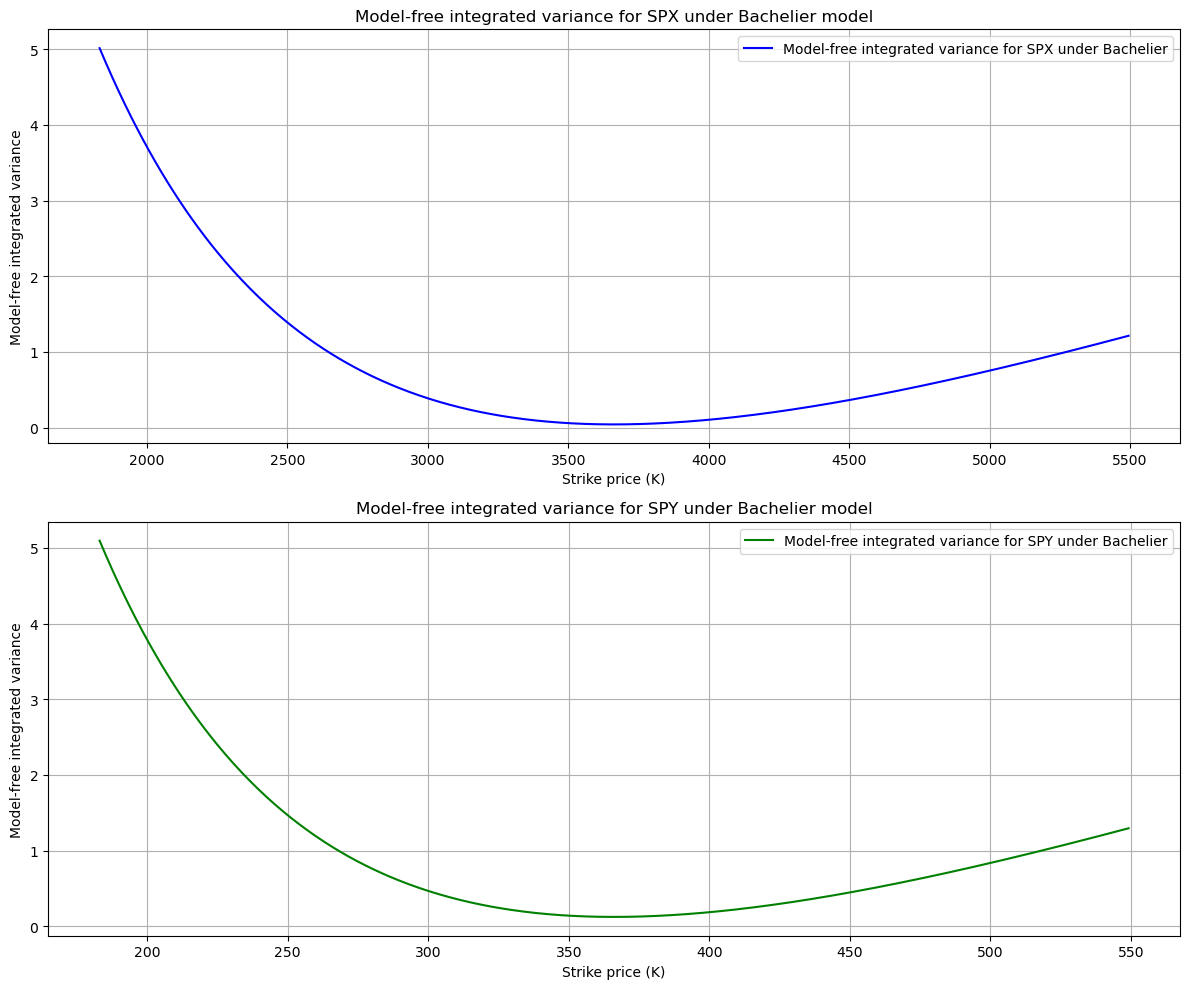

In [23]:
MF_SPX_Bav_values = []
MF_SPY_Bav_values = []

for K in K_values_X:
    I_SPX_call = quad(lambda x: C_Bav_int2(SPX_value, x, r, SPX_df_Bav_sigma, T), K, 5000)[0]
    I_SPX_put = quad(lambda x: P_Bav_int2(SPX_value, x, r, SPX_df_Bav_sigma, T), 0.0, K)[0]
    E_SPX_var = 2 * np.exp(r * T) * (I_SPX_call + I_SPX_put)
    MF_SPX_var_plot = E_SPX_var / T
    MF_SPX_Bav_values.append(MF_SPX_var_plot)

for K in K_values_Y:
    I_SPY_call = quad(lambda x: C_Bav_int2(SPY_value, x, r, SPY_df_Bav_sigma, T), K, 5000)[0]
    I_SPY_put = quad(lambda x: P_Bav_int2(SPY_value, x, r, SPY_df_Bav_sigma, T), 0.0, K)[0]
    E_SPY_var = 2 * np.exp(r * T) * (I_SPY_call + I_SPY_put)
    MF_SPY_var_plot = E_SPY_var / T
    MF_SPY_Bav_values.append(MF_SPY_var_plot)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(K_values_X, MF_SPX_Bav_values, label="Model-free integrated variance for SPX under Bachelier", color="blue")
ax1.set_xlabel("Strike price (K)")
ax1.set_ylabel("Model-free integrated variance")
ax1.set_title("Model-free integrated variance for SPX under Bachelier model")
ax1.legend()
ax1.grid(True)

ax2.plot(K_values_Y, MF_SPY_Bav_values, label="Model-free integrated variance for SPY under Bachelier", color="green")
ax2.set_xlabel("Strike price (K)")
ax2.set_ylabel("Model-free integrated variance")
ax2.set_title("Model-free integrated variance for SPY under Bachelier model")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [24]:
# “Model-free” integrated variance using the SABR model
def C_SABR_int2(S0, K, r, T, alpha, beta, rho, nu):
    return C_SABR(S0, K, r, T, alpha, beta, rho, nu) / K**2

def P_SABR_int2(S0, K, r, T, alpha, beta, rho, nu):
    return P_SABR(S0, K, r, T, alpha, beta, rho, nu) / K**2

I_SPX_call = quad(lambda x: C_SABR_int2(SPX_value, x, r, T, alpha_SPX, beta_SPX, rho_SPX, nu_SPX), F0_SPX, 5000)[0]
I_SPX_put = quad(lambda x: P_SABR_int2(SPX_value, x, r, T, alpha_SPX, beta_SPX, rho_SPX, nu_SPX), 1e-6, F0_SPX)[0]
I_SPY_call = quad(lambda x: C_SABR_int2(SPY_value, x, r, T, alpha_SPY, beta_SPY, rho_SPY, nu_SPY), F0_SPY, 5000)[0]
I_SPY_put = quad(lambda x: P_SABR_int2(SPY_value, x, r, T, alpha_SPY, beta_SPY, rho_SPY, nu_SPY), 1e-6, F0_SPY)[0]

E_SPX_var = 2 * np.exp(r * T) * (I_SPX_call + I_SPX_put)
E_SPY_var = 2 * np.exp(r * T) * (I_SPY_call + I_SPY_put)
print('The expected integrated variance for SPX under SABR is: %.9f' % E_SPX_var)
print('The expected integrated variance for SPY under SABR is: %.9f' % E_SPY_var)

MF_SPX_var = E_SPX_var/T
MF_SPY_var = E_SPY_var/T
print('The “model-free” integrated variance for SPX under SABR is: %.9f' % MF_SPX_var)
print('The “model-free” integrated variance for SPY under SABR is: %.9f' % MF_SPY_var)

print('Hence, the desired σ for SPX under SABR is: %.3f' % np.sqrt(MF_SPX_var))
print('Hence, the desired σ for SPY under SABR is: %.3f' % np.sqrt(MF_SPY_var))

The expected integrated variance for SPX under SABR is: 0.187326807
The expected integrated variance for SPY under SABR is: 0.006016079
The “model-free” integrated variance for SPX under SABR is: 1.519428550
The “model-free” integrated variance for SPY under SABR is: 0.048797086
Hence, the desired σ for SPX under SABR is: 1.233
Hence, the desired σ for SPY under SABR is: 0.221


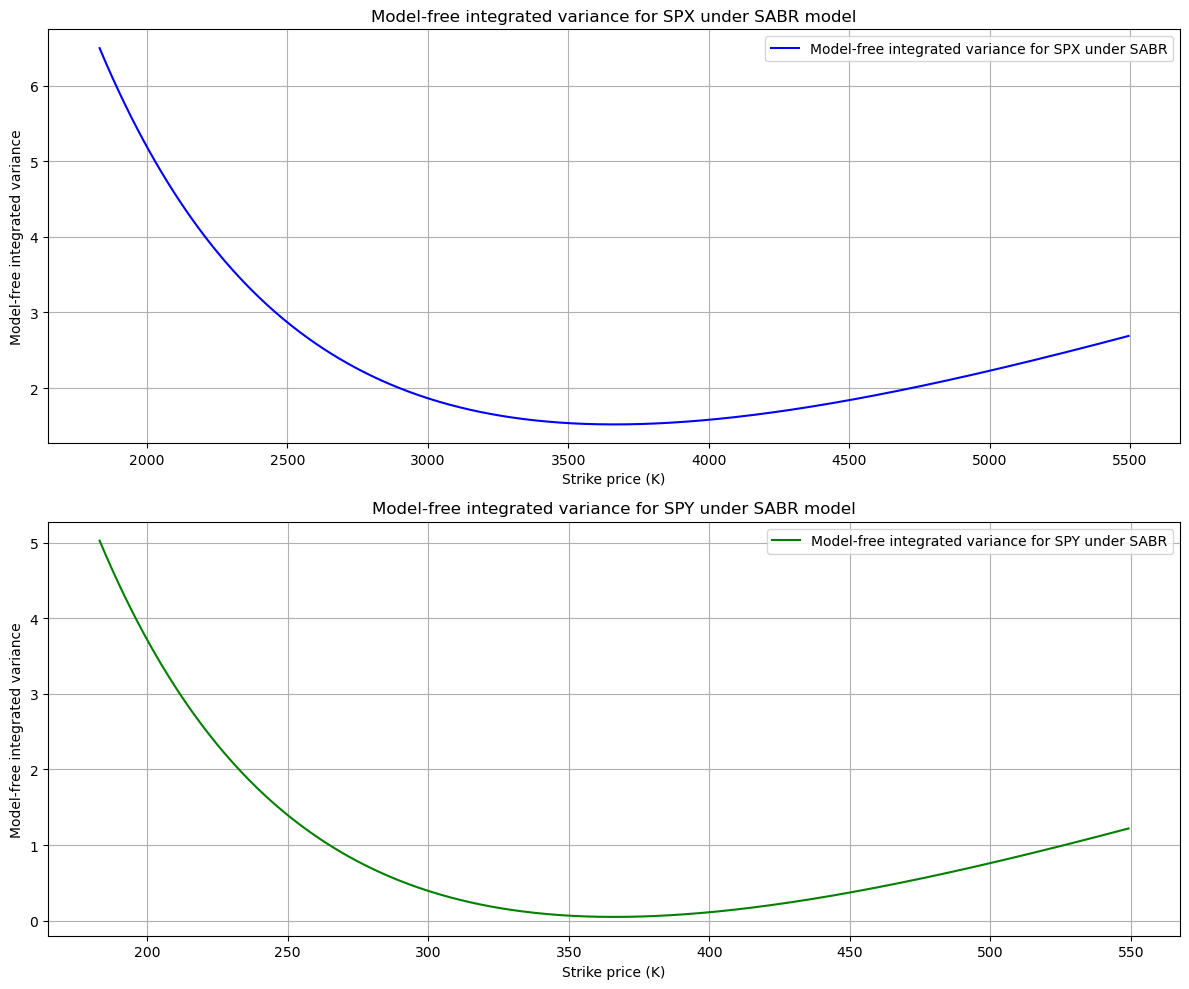

In [25]:
MF_SPX_SABR_values = []
MF_SPY_SABR_values = []

for K in K_values_X:
    I_SPX_call = quad(lambda x: C_SABR_int2(SPX_value, x, r, T, alpha_SPX, beta_SPX, rho_SPX, nu_SPX), K, 5000)[0]
    I_SPX_put = quad(lambda x: P_SABR_int2(SPX_value, x, r, T, alpha_SPX, beta_SPX, rho_SPX, nu_SPX), 0.0, K)[0]
    E_SPX_var = 2 * np.exp(r * T) * (I_SPX_call + I_SPX_put)
    MF_SPX_var_plot = E_SPX_var / T
    MF_SPX_SABR_values.append(MF_SPX_var_plot)

for K in K_values_Y:
    I_SPY_call = quad(lambda x: C_SABR_int2(SPY_value, x, r, T, alpha_SPY, beta_SPY, rho_SPY, nu_SPY), K, 5000)[0]
    I_SPY_put = quad(lambda x: P_SABR_int2(SPY_value, x, r, T, alpha_SPY, beta_SPY, rho_SPY, nu_SPY), 0.0, K)[0]
    E_SPY_var = 2 * np.exp(r * T) * (I_SPY_call + I_SPY_put)
    MF_SPY_var_plot = E_SPY_var / T
    MF_SPY_SABR_values.append(MF_SPY_var_plot)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(K_values_X, MF_SPX_SABR_values, label="Model-free integrated variance for SPX under SABR", color="blue")
ax1.set_xlabel("Strike price (K)")
ax1.set_ylabel("Model-free integrated variance")
ax1.set_title("Model-free integrated variance for SPX under SABR model")
ax1.legend()
ax1.grid(True)

ax2.plot(K_values_Y, MF_SPY_SABR_values, label="Model-free integrated variance for SPY under SABR", color="green")
ax2.set_xlabel("Strike price (K)")
ax2.set_ylabel("Model-free integrated variance")
ax2.set_title("Model-free integrated variance for SPY under SABR model")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Sensitivity analysis of the SABR model

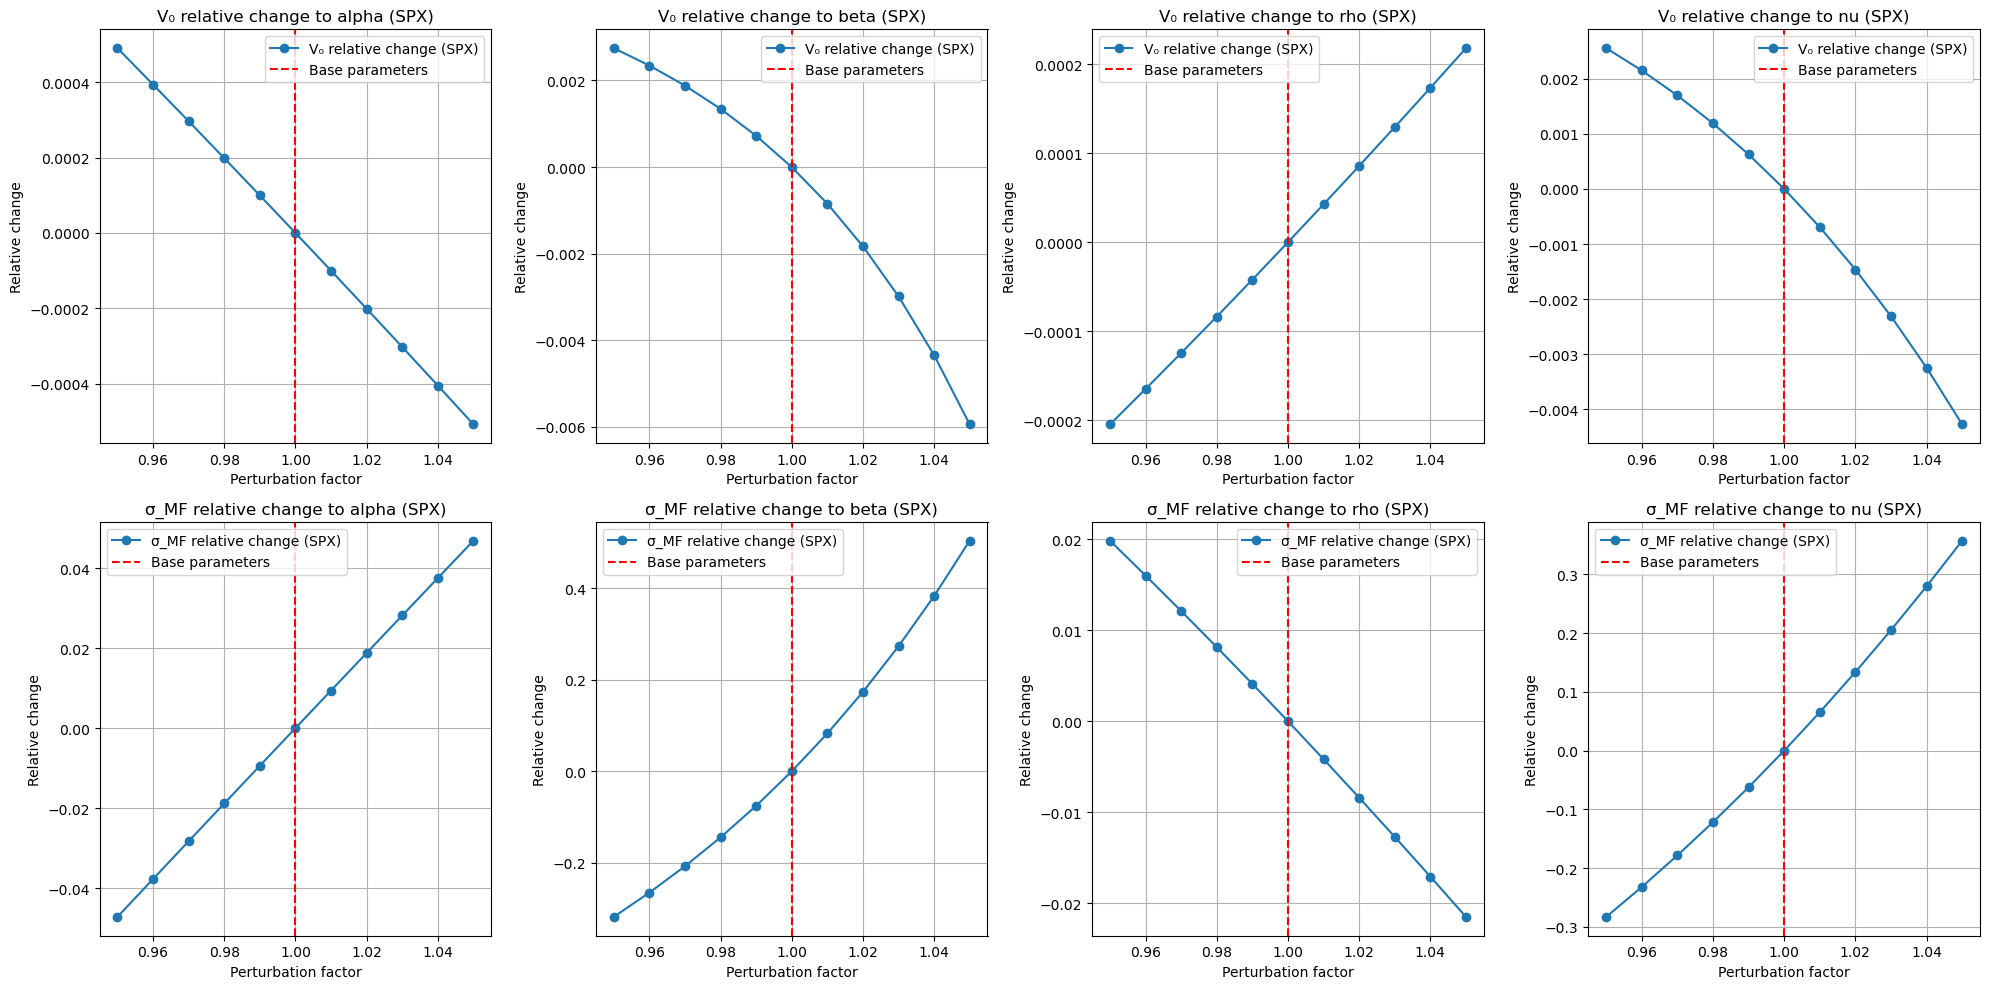

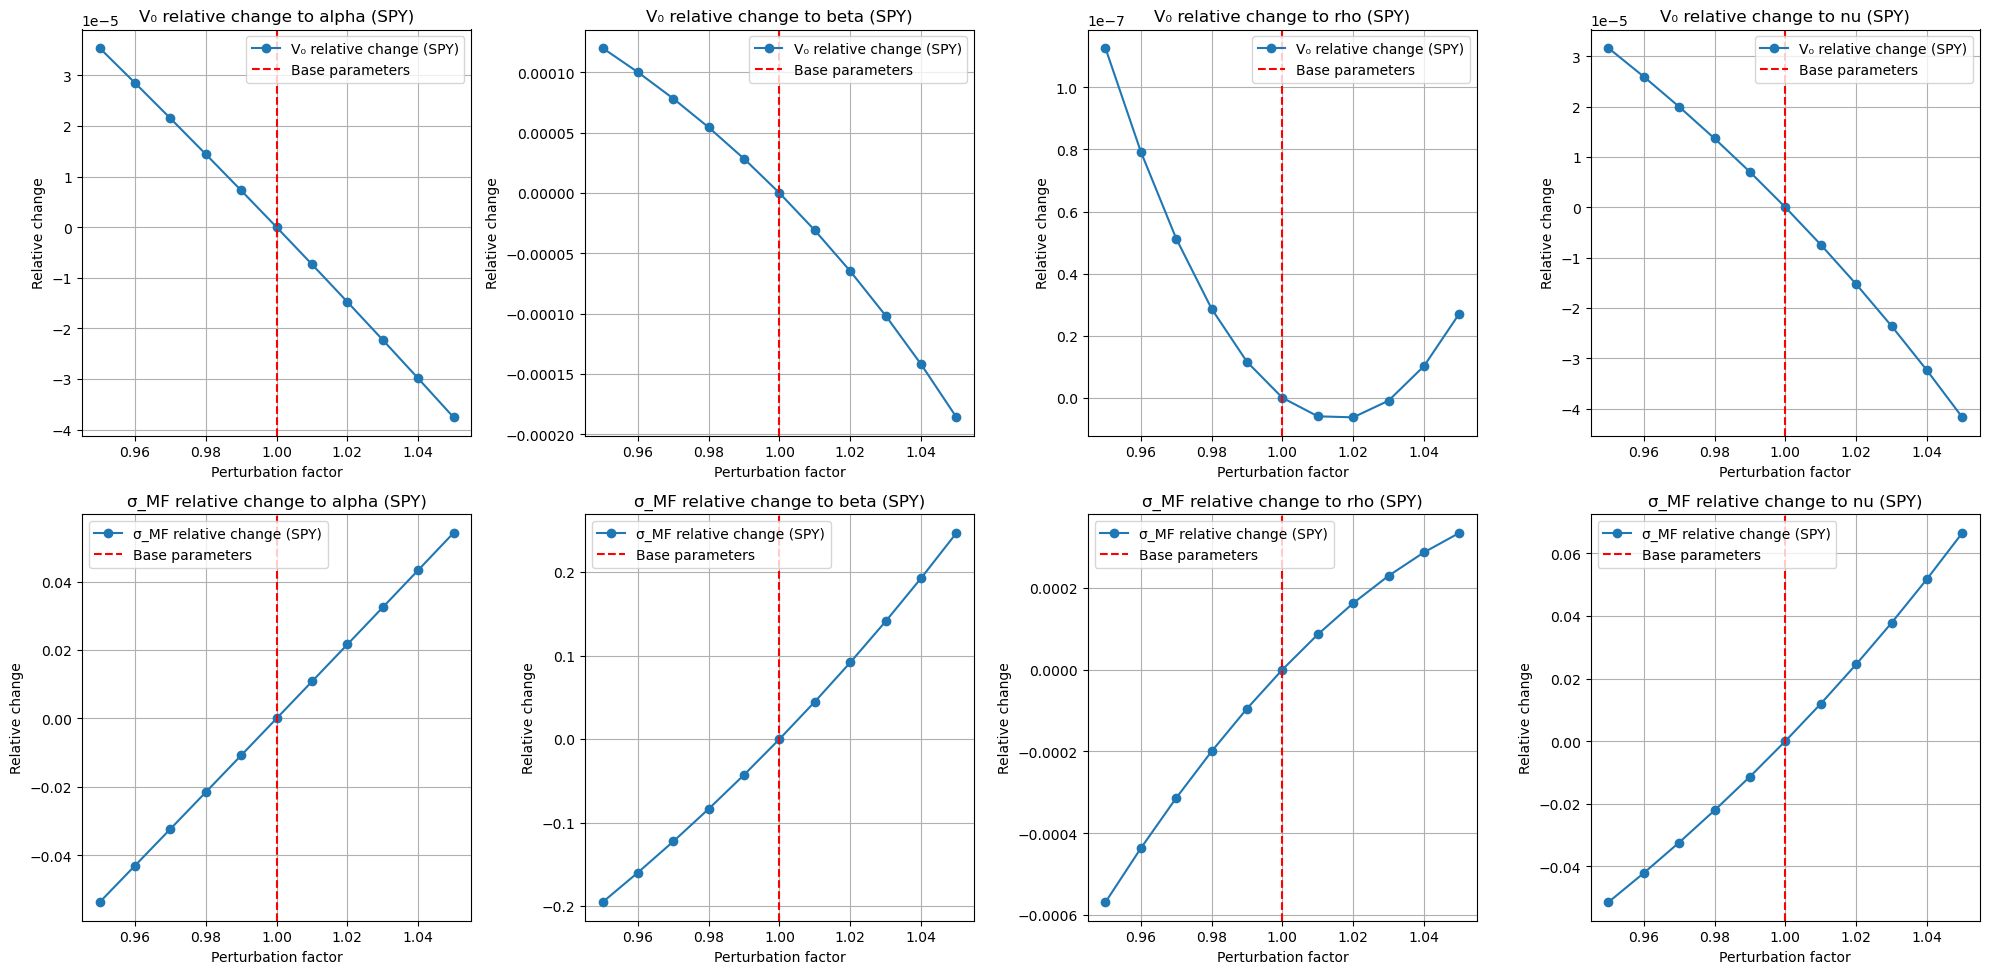

In [46]:
# Define perturbation range
perturbation_factors = np.linspace(0.95, 1.05, 11)  # +/- 5% perturbations
parameters = ["alpha", "beta", "rho", "nu"]

# Function to calculate sensitivities and relative changes
def sensitivity_analysis_relative(S0, F0, alpha, beta, rho, nu, label):
    V0_base = V0_SPX_SABR if label == "SPX" else V0_SPY_SABR
    sigma_MF_base = np.sqrt(MF_SPX_var) if label == "SPX" else np.sqrt(MF_SPY_var)

    V0_sensitivity = {param: [] for param in parameters}
    sigma_MF_sensitivity = {param: [] for param in parameters}

    for param in parameters:
        for factor in perturbation_factors:
            # Perturb one parameter at a time
            perturbed_alpha = alpha * factor if param == "alpha" else alpha
            perturbed_beta = beta * factor if param == "beta" else beta
            perturbed_rho = rho * factor if param == "rho" else rho
            perturbed_nu = nu * factor if param == "nu" else nu

            # Recalculate V₀
            I_call = quad(lambda x: C_SABR_int1(S0, x, r, T, perturbed_alpha, perturbed_beta, perturbed_rho, perturbed_nu), F0, 5000)[0]
            I_put = quad(lambda x: P_SABR_int1(S0, x, r, T, perturbed_alpha, perturbed_beta, perturbed_rho, perturbed_nu), 0.0, F0)[0]
            V0 = np.exp(-r * T) * h(F0) + I_call + I_put
            V0_relative_change = V0 / V0_base - 1
            V0_sensitivity[param].append(V0_relative_change)

            # Recalculate σ_MF
            I_call_var = quad(lambda x: C_SABR_int2(S0, x, r, T, perturbed_alpha, perturbed_beta, perturbed_rho, perturbed_nu), F0, 5000)[0]
            I_put_var = quad(lambda x: P_SABR_int2(S0, x, r, T, perturbed_alpha, perturbed_beta, perturbed_rho, perturbed_nu), 1e-6, F0)[0]
            E_var = 2 * np.exp(r * T) * (I_call_var + I_put_var)
            sigma_MF = np.sqrt(E_var / T)
            sigma_MF_relative_change = sigma_MF / sigma_MF_base - 1
            sigma_MF_sensitivity[param].append(sigma_MF_relative_change)

    # Plot results
    fig, axes = plt.subplots(2, len(parameters), figsize=(20, 10))

    for i, param in enumerate(parameters):
        # V₀ relative change
        axes[0, i].plot(perturbation_factors, V0_sensitivity[param], label=f"V₀ relative change ({label})", marker="o")
        axes[0, i].axvline(1.0, color="red", linestyle="--", label="Base parameters")
        axes[0, i].set_title(f"V₀ relative change to {param} ({label})")
        axes[0, i].set_xlabel("Perturbation factor")
        axes[0, i].set_ylabel("Relative change")
        axes[0, i].grid(True)
        axes[0, i].legend()

        # σ_MF relative change
        axes[1, i].plot(perturbation_factors, sigma_MF_sensitivity[param], label=f"σ_MF relative change ({label})", marker="o")
        axes[1, i].axvline(1.0, color="red", linestyle="--", label="Base parameters")
        axes[1, i].set_title(f"σ_MF relative change to {param} ({label})")
        axes[1, i].set_xlabel("Perturbation factor")
        axes[1, i].set_ylabel("Relative change")
        axes[1, i].grid(True)
        axes[1, i].legend()

    plt.tight_layout()
    plt.show()

# Perform sensitivity analysis for SPX and SPY
sensitivity_analysis_relative(SPX_value, F0_SPX, alpha_SPX, beta_SPX, rho_SPX, nu_SPX, "SPX")
sensitivity_analysis_relative(SPY_value, F0_SPY, alpha_SPY, beta_SPY, rho_SPY, nu_SPY, "SPY")